# Libraries

In [9]:
# Standard Libraries
import os
import random

# Scientific Libraries
import numpy as np
import pandas as pd
from scipy.signal import fftconvolve
from scipy.stats import pearsonr

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning & Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Audio Processing
import librosa
import soundfile as sf
import torchaudio
import pyroomacoustics as pra

# Evaluation Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Utility
from tqdm import tqdm

# Data Generation

### Create required output directories and define global simulation parameters.

In [19]:
# Create output folders
os.makedirs("features", exist_ok=True)
os.makedirs("labels", exist_ok=True)
os.makedirs("dry_speech", exist_ok=True)

# CONFIG
SAMPLE_RATE = 16000
NUM_SAMPLES = 10000
DRY_SPEECH_FOLDER = "dry_speech"  # Add your .wav files here
N_MELS = 64

### Download a small subset of LibriSpeech and save 50 mono audio samples into the dry_speech folder, resampling to 16kHz.

In [15]:
# Set destination folder
os.makedirs("dry_speech", exist_ok=True)

# Download a small LibriSpeech subset
dataset = torchaudio.datasets.LIBRISPEECH(root=".", url="train-clean-100", download=True)

# Save the first 50 samples into dry_speech/
for i in range(50):
    waveform, sample_rate, _, _, _, _ = dataset[i]
    
    # Resample if needed
    if sample_rate != 16000:
        waveform = torchaudio.functional.resample(waveform, sample_rate, 16000)
        sample_rate = 16000

    # Save as mono .wav file
    mono = waveform.mean(dim=0).numpy()
    sf.write(f"dry_speech/sample_{i:03d}.wav", mono, sample_rate)

print("✅ Saved 50 clean speech files to dry_speech/")

✅ Saved 50 clean speech files to dry_speech/


### Define helper functions for generating random room dimensions and positions, computing DRR and C50 from an RIR, and extracting log-mel spectrogram features from audio.

In [21]:
def get_random_room():
    # Random room dimensions (in meters)
    return [
        np.random.uniform(3.0, 10.0),  # x
        np.random.uniform(3.0, 10.0),  # y
        np.random.uniform(2.5, 4.0)    # z
    ]

def get_random_position(room):
    margin = 0.5  # stay away from walls
    return [
        np.random.uniform(margin, room[0] - margin),
        np.random.uniform(margin, room[1] - margin),
        np.random.uniform(margin, room[2] - margin)
    ]

def compute_drr(rir, sr, window_ms=3):
    peak_idx = np.argmax(np.abs(rir))          # locate direct sound
    d = int(window_ms * 0.001 * sr)            # e.g. 3 ms window
    direct_energy = np.sum(rir[peak_idx : peak_idx + d] ** 2)
    reverb_energy = np.sum(np.delete(rir, slice(peak_idx, peak_idx + d)) ** 2)
    return 10 * np.log10((direct_energy + 1e-10) / (reverb_energy + 1e-10))

def compute_c50(rir, sr):
    idx = int(0.05 * sr)
    early = np.sum(rir[:idx] ** 2)
    late = np.sum(rir[idx:] ** 2)
    return 10 * np.log10((early + 1e-10) / (late + 1e-10))

def extract_logmel(audio, sr, n_mels=N_MELS):
    mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
    logmel = librosa.power_to_db(mel, ref=np.max)
    return logmel

### List all `.wav` files available in the dry_speech folder for use in the data generation loop.

In [23]:
# Load list of available dry speech files
dry_files = [os.path.join(DRY_SPEECH_FOLDER, f)
             for f in os.listdir(DRY_SPEECH_FOLDER)
             if f.endswith(".wav")]

print(f"{len(dry_files)} dry speech files found.")

50 dry speech files found.


### Simulate reverberant audio samples using pyroomacoustics by:
- Generating a random room and mic/source position
- Loading a random dry speech sample
- Simulating the room impulse response (RIR)
- Convolving dry audio with RIR
- Extracting log-mel features
- Saving both the features and their corresponding labels (RT60, DRR, C50)

In [34]:
for i in tqdm(range(NUM_SAMPLES)):
    # 1. Random room setup
    room_dim = get_random_room()
    rt60_target = np.random.uniform(0.2, 1.5)
    e_abs, max_order = pra.inverse_sabine(rt60_target, room_dim)

    # 2. Random positions
    mic_pos = get_random_position(room_dim)
    src_pos = get_random_position(room_dim)

    # 3. Choose dry speech
    dry_path = random.choice(dry_files)
    dry_audio, _ = librosa.load(dry_path, sr=SAMPLE_RATE)
    dry_audio = dry_audio[:SAMPLE_RATE * 5]  # Trim to 5s

    # 4. Simulate room
    room = pra.ShoeBox(room_dim, fs=SAMPLE_RATE,
                       materials=pra.Material(e_abs),
                       max_order=max_order)
    room.add_source(src_pos, signal=dry_audio)
    room.add_microphone_array(pra.MicrophoneArray(np.array([mic_pos]).T, SAMPLE_RATE))
    room.simulate()

    rir = room.rir[0][0]
    reverb = fftconvolve(dry_audio, rir)[:len(dry_audio)]

    # 5. Compute parameters
    rt60 = pra.experimental.measure_rt60(rir, fs=SAMPLE_RATE)
    drr = compute_drr(rir, SAMPLE_RATE)
    c50 = compute_c50(rir, SAMPLE_RATE)

    # 6. Extract features
    logmel = extract_logmel(reverb, SAMPLE_RATE)

    # 7. Save
    np.save(f"features/sample_{i:05d}.npy", logmel)
    np.save(f"labels/sample_{i:05d}.npy", np.array([rt60, drr, c50]))

100%|███████████████████████████████████| 10000/10000 [1:31:10<00:00,  1.83it/s]


### Count and display the number of generated feature and label files to ensure the dataset was correctly created.

In [25]:
feature_files = sorted([f for f in os.listdir("features") if f.endswith(".npy")])
label_files = sorted([f for f in os.listdir("labels") if f.endswith(".npy")])

print(f"Features: {len(feature_files)}, Labels: {len(label_files)}")

Features: 10000, Labels: 10000


### Load and display one sample's log-mel spectrogram along with its RT60, DRR, and C50 values.

Feature shape: (64, 157)
Label (RT60, DRR, C50): [  2.5729375  -19.05198664 -12.26790413]


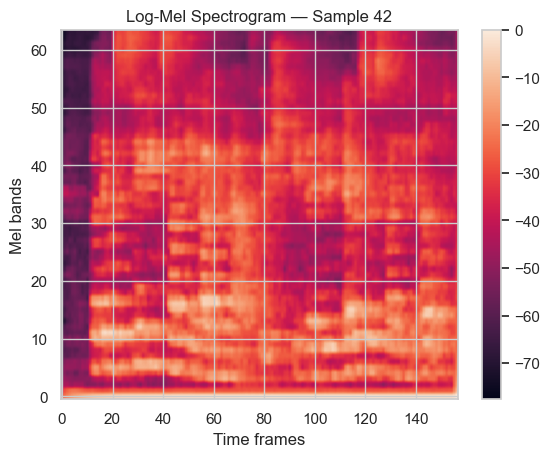

In [27]:
# Pick one sample
idx = 42  # change this to inspect different ones

feature = np.load(f"features/sample_{idx:05d}.npy")
label = np.load(f"labels/sample_{idx:05d}.npy")

print("Feature shape:", feature.shape)
print("Label (RT60, DRR, C50):", label)

# Visualize log-mel spectrogram
plt.imshow(feature, aspect='auto', origin='lower')
plt.title(f"Log-Mel Spectrogram — Sample {idx}")
plt.xlabel("Time frames")
plt.ylabel("Mel bands")
plt.colorbar()
plt.show()

### Extract all RT60 values from label files and plot their histogram to visualize the reverberation time distribution in the simulated dataset.

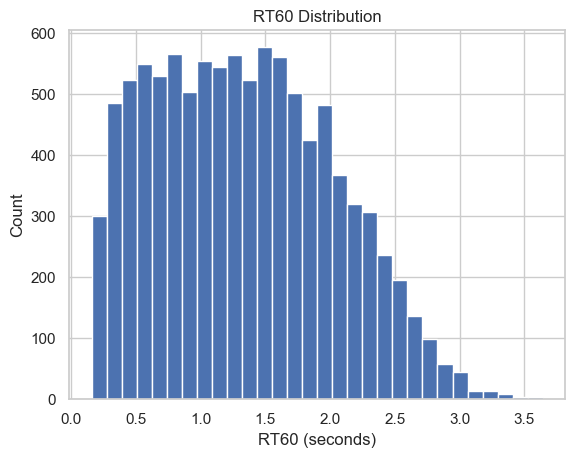

In [30]:
rt60s, drrs, c50s = [], [], []

for i in range(len(label_files)):
    label = np.load(f"labels/sample_{i:05d}.npy")
    rt60s.append(label[0])
    drrs.append(label[1])
    c50s.append(label[2])

plt.hist(rt60s, bins=30)
plt.title("RT60 Distribution")
plt.xlabel("RT60 (seconds)")
plt.ylabel("Count")
plt.show()

### Define a function to check for NaNs or Infs in saved feature files and scan all generated features for potential corruption.

In [32]:
def check_nan_or_inf(filepath):
    data = np.load(filepath)
    if np.isnan(data).any() or np.isinf(data).any():
        return True
    return False

corrupt = [f for f in feature_files if check_nan_or_inf(os.path.join("features", f))]

print(f"Corrupt files: {len(corrupt)}")

Corrupt files: 0


# Model Training

### Define Custom PyTorch Dataset (RIRDataset)
Defines a dataset class that loads saved log-mel feature and label `.npy` files, normalizes inputs, and returns fixed-length tensors for training.

In [44]:
class RIRDataset(Dataset):
    def __init__(self, features_dir="features", labels_dir="labels", max_len=160):
        self.features_dir = features_dir
        self.labels_dir = labels_dir
        self.file_list = sorted([
            f for f in os.listdir(features_dir) if f.endswith(".npy")
        ])
        self.max_len = max_len

        self.label_mean = np.array([1.5, -100.0, -4.0], dtype=np.float32)
        self.label_std = np.array([0.75, 10.0, 3.0], dtype=np.float32)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        x = np.load(os.path.join(self.features_dir, self.file_list[idx])).astype(np.float32)
        y = np.load(os.path.join(self.labels_dir, self.file_list[idx])).astype(np.float32)

        x = (x - np.mean(x)) / (np.std(x) + 1e-8)

        if x.shape[1] < self.max_len:
            x = np.pad(x, ((0, 0), (0, self.max_len - x.shape[1])), mode='constant')
        elif x.shape[1] > self.max_len:
            x = x[:, :self.max_len]

        y = (y - self.label_mean) / self.label_std
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


### Split Dataset into Training and Validation Sets
Splits the dataset into 80% training and 20% validation and prepares DataLoaders for each. Sets num_workers=0 for Jupyter compatibility.

In [47]:
dataset = RIRDataset()
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

# ✅ Set num_workers=0 for Jupyter notebooks
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_set, batch_size=32, num_workers=0)

### Define the CRNN Model Architecture
Creates a Convolutional Recurrent Neural Network (CRNN) that combines CNN layers for feature extraction and a GRU for temporal modeling. Outputs 3 regression targets: RT60, DRR, and C50.

In [37]:
class CRNN(nn.Module):
    def __init__(self, n_mels=64, hidden_size=64, output_size=3):
        super(CRNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d((2, 2)),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d((2, 2))
        )
        self.gru = nn.GRU(32 * (n_mels // 4), hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.unsqueeze(1)  # (B, 1, M, T)
        x = self.cnn(x)     # (B, C, M', T')
        x = x.permute(0, 3, 1, 2)  # (B, T', C, M')
        x = x.reshape(x.size(0), x.size(1), -1)  # (B, T', C*M')
        _, h = self.gru(x)
        return self.fc(h[-1])


### Train the CRNN Model
Defines the full training loop, using MSE loss and the Adam optimizer. Includes validation logic and logs loss per epoch for later plotting.

In [51]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = CRNN().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_losses, val_losses = [], []

for epoch in range(15):
    model.train()
    total_train_loss = 0

    for features, labels in train_loader:
        # ✅ Cast to float32 for MPS
        features, labels = features.to(device).float(), labels.to(device).float()

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    train_loss = total_train_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for features, labels in val_loader:
            features, labels = features.to(device).float(), labels.to(device).float()
            outputs = model(features)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    val_loss = total_val_loss / len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


Epoch 1 | Train Loss: 3.5444 | Val Loss: 2.2327
Epoch 2 | Train Loss: 2.0789 | Val Loss: 1.3275
Epoch 3 | Train Loss: 0.5607 | Val Loss: 0.2613
Epoch 4 | Train Loss: 0.1935 | Val Loss: 0.1743
Epoch 5 | Train Loss: 0.1471 | Val Loss: 0.1405
Epoch 6 | Train Loss: 0.1292 | Val Loss: 0.1257
Epoch 7 | Train Loss: 0.1172 | Val Loss: 0.1096
Epoch 8 | Train Loss: 0.1057 | Val Loss: 0.0991
Epoch 9 | Train Loss: 0.1007 | Val Loss: 0.0899
Epoch 10 | Train Loss: 0.0918 | Val Loss: 0.0831
Epoch 11 | Train Loss: 0.0878 | Val Loss: 0.0855
Epoch 12 | Train Loss: 0.0790 | Val Loss: 0.0760
Epoch 13 | Train Loss: 0.0748 | Val Loss: 0.0698
Epoch 14 | Train Loss: 0.0685 | Val Loss: 0.0804
Epoch 15 | Train Loss: 0.0686 | Val Loss: 0.0679


### Plot Training and Validation Loss Curves
Visualizes how the model's training and validation MSE loss changed over epochs. Helps assess convergence and potential overfitting.

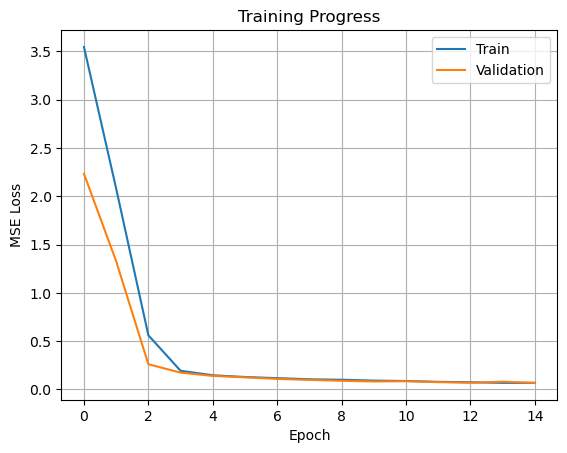

In [53]:
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Progress")
plt.legend()
plt.grid()
plt.show()

### Inspect Predictions vs Ground Truth
Runs inference on a few samples from the validation set and prints both the true and predicted values (denormalized) for RT60, DRR, and C50.

In [55]:
label_mean = np.array([1.5, -100.0, -4.0])
label_std = np.array([0.75, 10.0, 3.0])

model.eval()
for i in range(5):
    features, labels = val_set[i]
    with torch.no_grad():
        pred = model(features.unsqueeze(0).to(device)).cpu().numpy().squeeze()

    pred_denorm = pred * label_std + label_mean
    true_denorm = labels.numpy() * label_std + label_mean

    print(f"True : {true_denorm}")
    print(f"Pred : {pred_denorm}")
    print("-" * 30)


True : [  1.20725001 -13.3363533   -5.44032621]
Pred : [  1.20756197 -16.33876801  -6.42111224]
------------------------------
True : [ 0.3909376  -8.92002106  2.5291698 ]
Pred : [ 0.62928745 -7.79743195  2.68996215]
------------------------------
True : [  2.00187492 -20.29931545 -11.61035323]
Pred : [  2.07439287 -22.48318195 -12.49283576]
------------------------------
True : [  1.84031249 -14.63048935  -7.45224047]
Pred : [  1.82096346 -12.8246212   -6.70473456]
------------------------------
True : [  1.69868756 -16.49129868  -7.50625801]
Pred : [  1.93208764 -15.29556274  -7.82689607]
------------------------------


### Save and Reload the Trained Model
Saves the trained model weights to a `.pt` file for reuse and shows how to load it later for inference or further training.

In [57]:
os.makedirs("models", exist_ok=True)

In [59]:
torch.save(model.state_dict(), "models/crnn_base_model.pt")

In [61]:
model = CRNN().to(device)
model.load_state_dict(torch.load("models/crnn_base_model.pt"))
model.eval()

CRNN(
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (gru): GRU(512, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=3, bias=True)
)

# Model Optimisation

## CRNN Model Optimization — Bidirectional GRU + Dropout + Weighted Loss

This version of the notebook contains an optimized implementation of the CRNN model for predicting RT60, DRR, and C50 from simulated reverberant log-mel spectrograms. The following key improvements were introduced compared to the baseline:

### Changes Implemented
- **Dropout Layers**: Added after convolutional layers to prevent overfitting and improve generalization.
- **Bidirectional GRU**: Switched to a bidirectional recurrent layer to capture context from both past and future time steps in the sequence.
- **Weighted MSE Loss**: Applied custom weights `[1.0, 0.25, 0.5]` to balance the loss contribution of RT60, DRR, and C50 due to their different value scales and variances.
- **Extended Training**: Increased training epochs from 15 to 30 to allow more gradual convergence with the regularized model.

### Performance Improvements
| Metric | MAE (↓) | RMSE (↓) | R² (↑) | Pearson r (↑) |
|--------|----------|----------|--------|----------------|
| RT60   | 0.129 s  | 0.180 s  | 0.929  | 0.964          |
| DRR    | 1.63 dB  | 2.33 dB  | 0.868  | 0.942          |
| C50    | 0.51 dB  | 0.69 dB  | 0.990  | 0.996          |

The optimized model shows consistent improvements in R² and Pearson correlation across all targets, indicating better predictive power and stronger alignment with true labels, especially for C50.

This version is intended for final evaluation, comparison against real-world inference, and integration into the rendering pipeline.

In [34]:
class RIRDataset(Dataset):
    def __init__(self, features_dir="features", labels_dir="labels", max_len=160):
        self.features_dir = features_dir
        self.labels_dir = labels_dir
        self.file_list = sorted([
            f for f in os.listdir(features_dir) if f.endswith(".npy")
        ])
        self.max_len = max_len
        self.label_mean = np.array([1.5, -100.0, -4.0], dtype=np.float32)
        self.label_std = np.array([0.75, 10.0, 3.0], dtype=np.float32)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        x = np.load(os.path.join(self.features_dir, self.file_list[idx])).astype(np.float32)
        y = np.load(os.path.join(self.labels_dir, self.file_list[idx])).astype(np.float32)

        x = (x - np.mean(x)) / (np.std(x) + 1e-8)

        if x.shape[1] < self.max_len:
            x = np.pad(x, ((0, 0), (0, self.max_len - x.shape[1])), mode='constant')
        elif x.shape[1] > self.max_len:
            x = x[:, :self.max_len]

        y = (y - self.label_mean) / self.label_std
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [36]:
dataset = RIRDataset()
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_set, batch_size=32, num_workers=0)

In [38]:
class CRNN(nn.Module):
    def __init__(self, n_mels=64, hidden_size=64, output_size=3):
        super(CRNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Dropout(0.25),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Dropout(0.25)
        )

        self.gru = nn.GRU(input_size=32 * (n_mels // 4),
                          hidden_size=hidden_size,
                          batch_first=True,
                          bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.cnn(x)
        x = x.permute(0, 3, 1, 2)
        x = x.reshape(x.size(0), x.size(1), -1)
        _, h = self.gru(x)
        h_concat = torch.cat([h[0], h[1]], dim=1)
        return self.fc(h_concat)

In [69]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = CRNN().to(device)

# Weights to balance RT60, DRR, and C50
loss_weights = torch.tensor([1.0, 0.25, 0.5], device=device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_losses, val_losses = [], []

for epoch in range(30):
    model.train()
    total_train_loss = 0

    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = ((outputs - labels) ** 2 * loss_weights).mean()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    train_loss = total_train_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for features, labels in val_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = ((outputs - labels) ** 2 * loss_weights).mean()
            total_val_loss += loss.item()

    val_loss = total_val_loss / len(val_loader)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

Epoch 1 | Train Loss: 0.7703 | Val Loss: 0.2217
Epoch 2 | Train Loss: 0.1454 | Val Loss: 0.1475
Epoch 3 | Train Loss: 0.1083 | Val Loss: 0.1157
Epoch 4 | Train Loss: 0.0944 | Val Loss: 0.1216
Epoch 5 | Train Loss: 0.0861 | Val Loss: 0.1269
Epoch 6 | Train Loss: 0.0792 | Val Loss: 0.0766
Epoch 7 | Train Loss: 0.0742 | Val Loss: 0.0846
Epoch 8 | Train Loss: 0.0667 | Val Loss: 0.0652
Epoch 9 | Train Loss: 0.0648 | Val Loss: 0.0780
Epoch 10 | Train Loss: 0.0603 | Val Loss: 0.0610
Epoch 11 | Train Loss: 0.0566 | Val Loss: 0.0610
Epoch 12 | Train Loss: 0.0543 | Val Loss: 0.0542
Epoch 13 | Train Loss: 0.0533 | Val Loss: 0.0543
Epoch 14 | Train Loss: 0.0506 | Val Loss: 0.0545
Epoch 15 | Train Loss: 0.0484 | Val Loss: 0.0552
Epoch 16 | Train Loss: 0.0474 | Val Loss: 0.0466
Epoch 17 | Train Loss: 0.0444 | Val Loss: 0.0513
Epoch 18 | Train Loss: 0.0452 | Val Loss: 0.0373
Epoch 19 | Train Loss: 0.0424 | Val Loss: 0.0497
Epoch 20 | Train Loss: 0.0408 | Val Loss: 0.0413
Epoch 21 | Train Loss: 0.0395

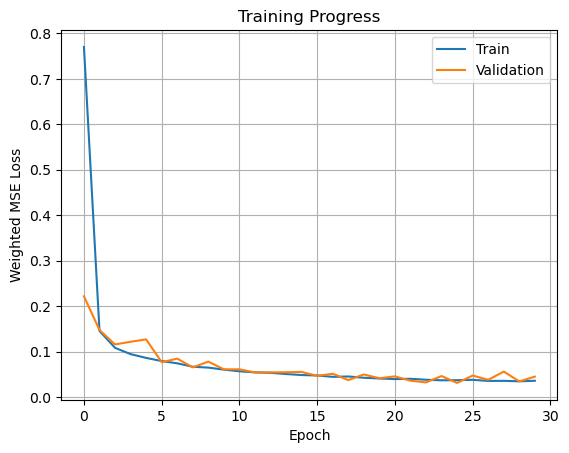

In [71]:
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Weighted MSE Loss")
plt.title("Training Progress")
plt.legend()
plt.grid()
plt.show()

In [73]:
label_mean = np.array([1.5, -100.0, -4.0])
label_std = np.array([0.75, 10.0, 3.0])

errors = []

model.eval()
with torch.no_grad():
    for features, labels in val_loader:
        features, labels = features.to(device), labels.to(device)
        preds = model(features)

        preds = preds.cpu().numpy() * label_std + label_mean
        true = labels.cpu().numpy() * label_std + label_mean
        errors.append(np.abs(preds - true))

errors = np.concatenate(errors, axis=0)
mae = np.mean(errors, axis=0)

print(f"RT60 MAE: {mae[0]:.3f} s")
print(f"DRR  MAE: {mae[1]:.2f} dB")
print(f"C50  MAE: {mae[2]:.2f} dB")

RT60 MAE: 0.157 s
DRR  MAE: 1.59 dB
C50  MAE: 0.62 dB


In [75]:
model.eval()
y_preds = []
y_trues = []

with torch.no_grad():
    for x_batch, y_batch in val_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        preds = model(x_batch)
        y_preds.append(preds.cpu().numpy())
        y_trues.append(y_batch.cpu().numpy())

# Stack batches
y_pred = np.vstack(y_preds)
y_true = np.vstack(y_trues)

# Denormalize
label_mean = np.array([1.5, -100.0, -4.0])
label_std = np.array([0.75, 10.0, 3.0])
y_pred = y_pred * label_std + label_mean
y_true = y_true * label_std + label_mean

# Metrics for each parameter
names = ["RT60", "DRR", "C50"]
results = []
for i, name in enumerate(names):
    mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
    rmse = np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i]))
    r2 = r2_score(y_true[:, i], y_pred[:, i])
    r, _ = pearsonr(y_true[:, i], y_pred[:, i])
    
    results.append({
        "Metric": name,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "Pearson r": r
    })

metrics_df = pd.DataFrame(results)
display(metrics_df)

,Metric,MAE,RMSE,R2,Pearson r
0,RT60,0.156732,0.226884,0.893379,0.961591
1,DRR,1.587898,2.015163,0.901853,0.965623
2,C50,0.615108,0.775378,0.988205,0.996132


In [77]:
os.makedirs("models", exist_ok=True)

# Save only the model weights (recommended)
torch.save(model.state_dict(), "models/crnn_dropout_bigru_v1.pt")
print("✅ Model saved to models/crnn_dropout_bigru_v1.pt")

✅ Model saved to models/crnn_dropout_bigru_v1.pt


In [41]:
# Recreate model structure first
model = CRNN().to(device)

# Load the weights
model.load_state_dict(torch.load("models/crnn_dropout_bigru_v1.pt"))
model.eval()

print("✅ Model loaded and ready for inference.")

✅ Model loaded and ready for inference.
